In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

BASE_DATA_DIR = "../../data"
QNA_DATA_DIR = f"{BASE_DATA_DIR}/lernnavi/qna"
ORIGINAL_DATA_DIR = f"{BASE_DATA_DIR}/original/data"

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MCQDataset(torch.utils.data.Dataset):
    """
        
    """

    _nlp_model = None

    @property
    def nlp_model(self):
        if MCQDataset._nlp_model:
            return MCQDataset._nlp_model
        
        from sentence_transformers import SentenceTransformer
        MCQDataset._nlp_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
        return MCQDataset._nlp_model


    def __init__(self, datapath, seq_len=5):
        self.datapath = datapath
        self.seq_len = seq_len

        import os
        self.df = pd.read_pickle(self.datapath)
            
        # preprocess topic data
        self.df['question_embedding'] = self._create_q_embeddings()
        self.df['answer_embedding']= self._create_a_embeddings()

    def _create_q_embeddings(self):
        # create embeddings for each topic
        embeddings = self.nlp_model.to(device).encode(self.df["question"], show_progress_bar=True, batch_size=2048)
        return list(map(lambda x: np.squeeze(x), np.split(embeddings, embeddings.shape[0])))
    def _create_a_embeddings(self):
        # create embeddings for each topic
        embeddings = self.nlp_model.to(device).encode(self.df["choice"], show_progress_bar=True, batch_size=2048)
        return list(map(lambda x: np.squeeze(x), np.split(embeddings, embeddings.shape[0])))
       
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self.df) + idx

        df2 = self.df[self.df["user_id"] == self.df.iloc[idx]["user_id"]].reset_index()
        df2 = df2.sort_values(by="start_time").reset_index(drop=True)
        indx = df2[df2["index"] == idx].index[0]

        
        if indx >= self.seq_len:
            seq_before = df2.iloc[indx-self.seq_len+1 : indx+1]
        else:
            seq_before = df2.iloc[0: indx+1]


        data = torch.stack(
            seq_before.apply(lambda x: np.concatenate((x['question_embedding'], x['answer_embedding'])), axis=1)
              .apply(lambda x: torch.tensor(x, dtype=torch.float32))
              .tolist()
        )

        return data

In [62]:
train_dataset = MCQDataset(f"{QNA_DATA_DIR}/train/qna_expanded.pkl")
val_dataset = MCQDataset(f"{QNA_DATA_DIR}/validation/qna_expanded.pkl")

Batches:   0%|          | 0/83 [00:00<?, ?it/s]

Batches:   0%|          | 0/83 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [93]:
from statistics import mean
from tqdm.auto import tqdm
from pathlib import Path
from torch.nn import MSELoss
import torch.nn as nn



# code from https://github.com/shobrook/sequitur

class Encoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ, out_activ):
        super(Encoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True,
            )
            self.layers.append(layer)

        self.h_activ, self.out_activ = h_activ, out_activ

    def forward(self, x):
        x = x.unsqueeze(0)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)
            elif self.out_activ and index == self.num_layers - 1:
                return self.out_activ(h_n).squeeze()

        return h_n.squeeze()


class Decoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ):
        super(Decoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [h_dims[-1]]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True,
            )
            self.layers.append(layer)

        self.h_activ = h_activ
        self.dense_matrix = nn.Parameter(
            torch.rand((layer_dims[-1], out_dim), dtype=torch.float), requires_grad=True
        )

    def forward(self, x, seq_len):
        x = x.repeat(seq_len, 1).unsqueeze(0)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)

        return torch.mm(x.squeeze(0), self.dense_matrix)


class LSTM_AE(nn.Module):
    def __init__(
        self,
        input_dim,
        encoding_dim,
        h_dims=[],
        h_activ=nn.Sigmoid(),
        out_activ=nn.Tanh(),
    ):
        super(LSTM_AE, self).__init__()

        self.encoder = Encoder(input_dim, encoding_dim, h_dims, h_activ, out_activ)
        self.decoder = Decoder(encoding_dim, input_dim, h_dims[::-1], h_activ)

    def forward(self, x):
        seq_len = x.shape[0]
        x = self.encoder(x)
        x = self.decoder(x, seq_len)

        return x


def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def instantiate_model(model, train_set, encoding_dim, **kwargs):
    if model.__name__ in ("LINEAR_AE", "LSTM_AE"):
        return model(train_set[-1].shape[-1], encoding_dim, **kwargs)
    elif model.__name__ == "CONV_LSTM_AE":
        if len(train_set[-1].shape) == 3:  # 2D elements
            return model(train_set[-1].shape[-2:], encoding_dim, **kwargs)
        elif len(train_set[-1].shape) == 4:  # 3D elements
            return model(train_set[-1].shape[-3:], encoding_dim, **kwargs)

@torch.no_grad()
def validate_model(model, val_set, epoch, criterion, device):
    model.eval()
    
    losses = []
    a = 0
    for x in tqdm(val_set, desc=f"Val Epoch {epoch: 3d}"):
        if a > 100:
            break
        a+=1

        x = x.to(device)
        x_prime = model(x)
        
        loss = criterion(x_prime, x)
        losses.append(loss.item())
        
    return mean(losses)
        

def train_model(
    model, train_set, val_set, verbose, lr, epochs, denoise, clip_value, device=None, save_path=Path("./checkpoints")
):
    if device is None:
        device = get_device()
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = MSELoss(reduction="sum")

    mean_losses = []
    val_losses = []
    for epoch in range(1, epochs + 1):
        model.train()

        # # Reduces learning rate every 50 epochs
        # if not epoch % 50:
        #     for param_group in optimizer.param_groups:
        #         param_group["lr"] = lr * (0.993 ** epoch)

        losses = []

        a = 0
        for x in tqdm(train_set, desc=f"Train Epoch {epoch: 3d}"):
            if a > 100:
                break
            a+=1

            x = x.to(device, non_blocking=True)
            
            optimizer.zero_grad()

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()
           

            # Gradient clipping on norm
            if clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)
        
        torch.save(model.state_dict(), str(save_path / f"model_{epoch:03d}.pt"))

        val_loss = validate_model(model, val_set, epoch, criterion, device)
        val_losses.append(val_loss)
        
        if verbose:
            print(f"Epoch: {epoch}, Train loss: {mean_loss}, Validation Loss: {val_loss}")

    return mean_losses, val_losses


@torch.no_grad()
def get_encodings(model, train_set, device=None):
    if device is None:
        device = get_device()
    model.eval()
    encodings = [model.encoder(x.to(device)) for x in tqdm(train_set)]
    return encodings


######
# MAIN
######


def quick_train(
    model,
    train_set,
    val_set,
    encoding_dim,
    verbose=False,
    lr=1e-3,
    epochs=100,
    clip_value=1,
    denoise=False,
    device=None,
    save_path=Path("../../checkpoints"),
    **kwargs,
):
    model = instantiate_model(model, train_set, encoding_dim, **kwargs)

    save_path.mkdir(parents=True, exist_ok=True)
    train_losses, val_losses = train_model(
        model, train_set, val_set, verbose, lr, epochs, denoise, clip_value, device, save_path
    )

    return model.encoder, model.decoder, train_losses, val_losses

In [104]:
trains = []
vals = []

for i in [10, 20, 30, 40]:
    train_dataset.seq_len = i
    val_dataset.seq_len = i

    for j in range(1, 4):
        print("=======================================")
        print("TRAINING BEGINS")
        print(f"seq_len: {i}")
        print(f"hidden_dims: {j}")
        print("=======================================")
        (
            encoder,
            decoder,
            train_losses,
            val_losses
        ) = quick_train(LSTM_AE, train_dataset, val_dataset, encoding_dim=384, verbose=True, epochs=3, h_dims=[384]*j, save_path=Path(f"../../checkpoints/seq_len_{i}_h_dims_{j}"))
        trains.append(train_losses)
        vals.append(val_losses)

results = pd.DataFrame({
    "train": trains,
    "val": vals,
    "train_min": np.min(trains, axis=1),
    "val_min": np.min(vals, axis=1),
    "seq_len": [10, 20, 30, 40] * 3,
    "h_dims": [1] * 4 + [2] * 4 + [3] * 4
})

results.to_pickle("../../checkpoints/lstm_results.pkl")

TRAINING BEGINS
seq_len: 10
hidden_dims: 1
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 11258.72031053222, Validation Loss: 61.817105604870484


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 170.40970696553146, Validation Loss: 52.35193657639003


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 135.20037634065835, Validation Loss: 50.80208467729021
TRAINING BEGINS
seq_len: 10
hidden_dims: 2
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 12484.276130393, Validation Loss: 60.65117969135247


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 146.4479677747972, Validation Loss: 48.93732961333624


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 129.91884482733093, Validation Loss: 49.66298193978791
TRAINING BEGINS
seq_len: 10
hidden_dims: 3
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 11014.353128112189, Validation Loss: 59.94092451227773


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 135.11463803584033, Validation Loss: 47.83656838860842


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 126.68687318103149, Validation Loss: 60.8347278160624
TRAINING BEGINS
seq_len: 20
hidden_dims: 1
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 12145.325727764923, Validation Loss: 94.27820400200268


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 190.36309727583782, Validation Loss: 50.24255547665133


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 218.26705074310303, Validation Loss: 49.27538899147864
TRAINING BEGINS
seq_len: 20
hidden_dims: 2
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 11877.202767929228, Validation Loss: 65.39093977862065


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 211.77917471970662, Validation Loss: 48.71565036962528


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 196.87376992065128, Validation Loss: 49.5326124512323
TRAINING BEGINS
seq_len: 20
hidden_dims: 3
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 10272.905362667423, Validation Loss: 51.129399337390865


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 190.11639707395346, Validation Loss: 47.62943597359232


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 186.54348382855406, Validation Loss: 50.59294982947925
TRAINING BEGINS
seq_len: 30
hidden_dims: 1
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 12514.854446373363, Validation Loss: 73.0844548291499


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 321.38445026095553, Validation Loss: 52.56680707648249


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 219.57464759184583, Validation Loss: 49.38494823002579
TRAINING BEGINS
seq_len: 30
hidden_dims: 2
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 10541.774037540548, Validation Loss: 73.88766489878739


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 253.66653453713596, Validation Loss: 48.30470933064376


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 228.12920840423885, Validation Loss: 50.00126055915757
TRAINING BEGINS
seq_len: 30
hidden_dims: 3
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 12793.261514342657, Validation Loss: 52.46050340822428


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 224.85624862897515, Validation Loss: 49.124207949874425


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 217.86550960918464, Validation Loss: 48.63361523883177
TRAINING BEGINS
seq_len: 40
hidden_dims: 1
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 13060.10839734219, Validation Loss: 86.71029272173891


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 272.7800179472064, Validation Loss: 48.84786611500353


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 239.4722224509362, Validation Loss: 48.62314623653299
TRAINING BEGINS
seq_len: 40
hidden_dims: 2
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 12148.85038687451, Validation Loss: 88.8094997972545


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 274.2436141023542, Validation Loss: 51.260244681103394


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 277.23722692055276, Validation Loss: 48.75203793591792
TRAINING BEGINS
seq_len: 40
hidden_dims: 3
cuda:0


Train Epoch   1:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   1:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 1, Train loss: 12478.266983938689, Validation Loss: 55.128254135056295


Train Epoch   2:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   2:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 2, Train loss: 267.947245116281, Validation Loss: 50.21764753360559


Train Epoch   3:   0%|          | 0/168748 [00:00<?, ?it/s]

Val Epoch   3:   0%|          | 0/19488 [00:00<?, ?it/s]

Epoch: 3, Train loss: 245.79116160326666, Validation Loss: 51.1650497039946


In [109]:
results = pd.DataFrame({
    "train": trains,
    "val": vals,
    "train_min": np.min(trains, axis=1),
    "val_min": np.min(vals, axis=1),
    "seq_len": [10, 20, 30, 40] * 3,
    "h_dims": [1] * 4 + [2] * 4 + [3] * 4
})

results.to_pickle("../../checkpoints/lstm_results.pkl")

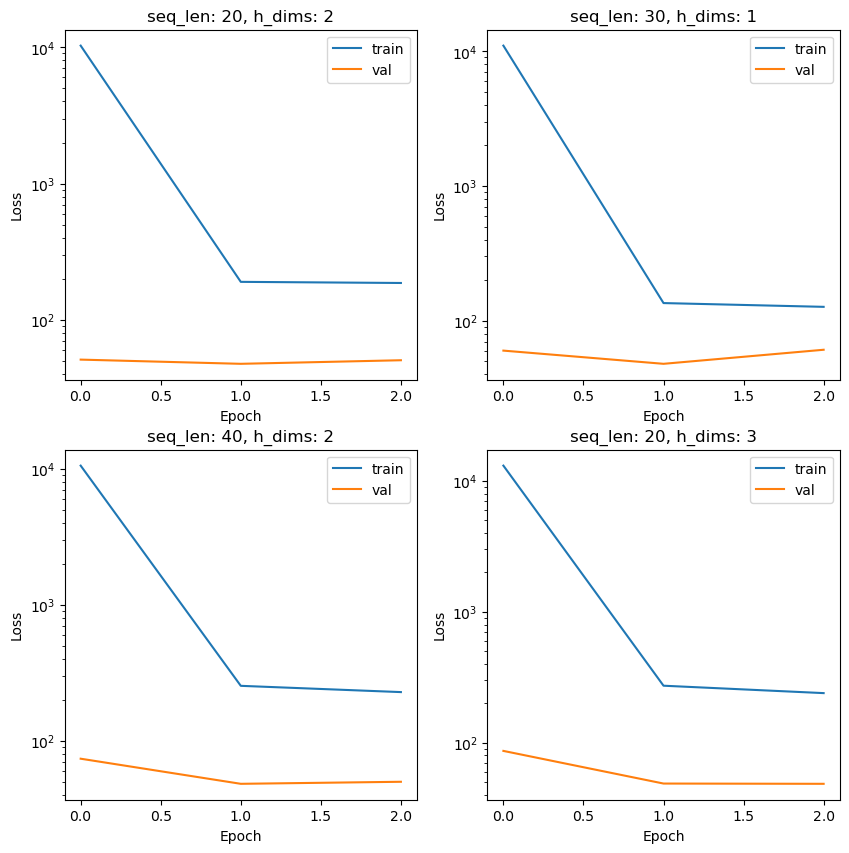

In [110]:
# plot the best 4 models
results = results.sort_values(by="val_min").reset_index(drop=True)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    axs[i].plot(results.iloc[i]["train"], label="train")
    axs[i].plot(results.iloc[i]["val"], label="val")
    axs[i].set_title(f"seq_len: {results.iloc[i]['seq_len']}, h_dims: {results.iloc[i]['h_dims']}")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Loss")
    axs[i].set_yscale("log")
    axs[i].legend()
plt.show()
# save plot
fig.savefig("../../checkpoints/lstm_results.png")

In [76]:
ckpt = torch.load("./model_004.pt")
mloaded = LSTM_AE(val_filtered[-1].shape[-1], 512, h_dims=[512, 512, 512])
mloaded.load_state_dict(ckpt)
mloaded = mloaded.to(device)

train_embeddings = get_encodings(mloaded, train_dataset)
val_embeddings = get_encodings(mloaded, val_dataset)
test_embeddings = get_encodings(mloaded, test_dataset)

  0%|          | 0/145620 [00:00<?, ?it/s]

  0%|          | 0/43006 [00:00<?, ?it/s]

  0%|          | 0/32351 [00:00<?, ?it/s]

In [96]:
output = "./train_qna_initial.pkl"
url = "https://drive.google.com/file/d/124QDhAo21G4jWOA9L-LIKMjZe8PY0zE0/view?usp=sharing"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

output = "./val_qna_initial.pkl"
url = "https://drive.google.com/file/d/1cnQGQ6Y--Cd3Ri_vQuOgsRmZ-BNhznoY/view?usp=sharing"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

output = "./test_qna_initial.pkl"
url = "https://drive.google.com/file/d/16Kis7d7tTu9SUwBT6kZt4kfKvW1M0q6d/view?usp=sharing"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=124QDhAo21G4jWOA9L-LIKMjZe8PY0zE0
To: /workspace/train_qna_initial.pkl
100%|██████████| 63.1M/63.1M [00:25<00:00, 2.52MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cnQGQ6Y--Cd3Ri_vQuOgsRmZ-BNhznoY
To: /workspace/val_qna_initial.pkl
100%|██████████| 18.9M/18.9M [00:01<00:00, 16.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Kis7d7tTu9SUwBT6kZt4kfKvW1M0q6d
To: /workspace/test_qna_initial.pkl
100%|██████████| 14.1M/14.1M [00:01<00:00, 12.6MB/s]


'./test_qna_initial.pkl'

In [97]:
train_csv = pd.read_csv("./train_qna.csv", )
train_csv['embeddings'] = list(map(lambda x: x.detach().cpu().numpy(), train_embeddings))

train_qna_pkl = pd.read_pickle("./train_qna_initial.pkl")[["user_id", "multiple_responses", "question", "choices", "correct", "student_answer", "start_time"]]
train_qna_pkl["embedding"] = train_csv.groupby("question_index").apply(lambda x: x.iloc[-1])["embeddings"]
train_qna_pkl.to_pickle("./train_pkl_with_embeddings")

In [98]:
val_csv = pd.read_csv("./val_qna.csv", )
val_csv['embeddings'] = list(map(lambda x: x.detach().cpu().numpy(), val_embeddings))

val_qna_pkl = pd.read_pickle("./val_qna_initial.pkl")[["user_id", "multiple_responses", "question", "choices", "correct", "student_answer", "start_time"]]
val_qna_pkl["embedding"] = val_csv.groupby("question_index").apply(lambda x: x.iloc[-1])["embeddings"]
val_qna_pkl.to_pickle("./val_pkl_with_embeddings")

In [99]:
test_csv = pd.read_csv("./test_qna.csv", )
test_csv['embeddings'] = list(map(lambda x: x.detach().cpu().numpy(), test_embeddings))

test_qna_pkl = pd.read_pickle("./test_qna_initial.pkl")[["user_id", "multiple_responses", "question", "choices", "correct", "student_answer", "start_time"]]
test_qna_pkl["embedding"] = test_csv.groupby("question_index").apply(lambda x: x.iloc[-1])["embeddings"]
test_qna_pkl.to_pickle("./test_pkl_with_embeddings")

In [104]:
qna_with_embeddings = pd.concat((train_qna_pkl, val_qna_pkl, test_qna_pkl), ignore_index=True)
qna_with_embeddings.to_pickle("merged_qna_with_embeddings.pkl")
qna_with_embeddings.head(2)

,user_id,multiple_responses,question,choices,correct,student_answer,start_time,embedding
0,387604,True,<p>Marlyne Sahakian ist Assistenzprofessorin a...,"[<p>…wundert sich darüber, dass SchweizerInnen...","[False, False, True, False]","[False, True, True, False]",2021-10-31 18:36:44.534,"[0.24643469, -0.05258508, 0.5322496, -0.043402..."
1,387604,True,<strong>Wähle die korrekte Pluralform(en) als ...,"[die Daten, die Data, die Datume]","[True, False, False]","[True, False, False]",2021-11-09 07:57:38.255,"[0.22013251, -0.052667905, 0.59776336, -0.0211..."


In [11]:
import pandas as pd

df = pd.read_pickle(r"/myhome/final-submission-extrapizzafosterslearning/data/lernnavi/qna/validation/qna_expanded.pkl")
len(df)

19488